# Sentiment Analysis of OTR App Store Reviews

In [1]:
!pip install app_store_scraper
!pip install wordcloud
!pip install textblob
!pip install pandas_profiling
!pip install seaborn

  Using cached requests-2.23.0-py2.py3-none-any.whl (58 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires requests>=2.24.0, but you have requests 2.23.0 which is incompatible.
dtale 2.8.1 requires scipy==1.7.3; python_version == "3.7", but you have scipy 1.7.1 which is incompatible.
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import string
import emoji
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Global Variables
appStore = "Apple"
appId = "1278446171" #For Apple 
appName =  "bd" #"mySugr" #"accuChek" #"OneTouchReveal" # 
country = "us"
appAnalysisFolderPath = "appAnalysis/{0}/{1}".format(appName,appStore)

In [4]:
# Folder Creation
import os

def createFolderIfNotExists(folderPath):
    if not os.path.exists(folderPath):
        print(folderPath)
        os.makedirs(folderPath)

In [5]:
# Create Output Folders
createFolderIfNotExists(appAnalysisFolderPath)
createFolderIfNotExists("{0}/data".format(appAnalysisFolderPath))
createFolderIfNotExists("{0}/result".format(appAnalysisFolderPath))
createFolderIfNotExists("{0}/result/wordCloud".format(appAnalysisFolderPath))
createFolderIfNotExists("{0}/profilerResults".format(appAnalysisFolderPath))

## 1. Data Collection

In [6]:
from app_store_scraper import AppStore

otr_reviews = AppStore(country=country, 
                       app_name=appName, 
                       app_id = appId
                       )
otr_reviews.review(how_many=1000000)

2022-09-29 20:42:28,159 [INFO] Base - Initialised: AppStore('us', 'bd', 1278446171)
2022-09-29 20:42:28,160 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/bd/id1278446171
2022-09-29 20:42:28,258 [INFO] Base - [id:1278446171] Fetched 11 reviews (11 fetched in total)


In [7]:
df = pd.DataFrame(np.array(otr_reviews.reviews),columns=['review'])
df_otr = df.join(pd.DataFrame(df.pop('review').tolist()))

In [8]:
df = df_otr
# Drop index column and Extract df into a csv file
reviewsOutputFilePath = "{0}/data/{1}-PlayStore_Reviews.csv".format(appAnalysisFolderPath, appName)

df_otr.to_csv(reviewsOutputFilePath, index=False)

df.head(5)

,isEdited,date,rating,title,review,userName,developerResponse
0,False,2017-10-01 20:32:11,5,Cool idea,Content is really strong. The chat bot seems ...,Ohmssbond,NaN
1,False,2019-03-07 18:13:45,2,Needs more for meal tracking,This is a pretty good app for basic needs. You...,dvh :),NaN
2,False,2018-05-14 04:29:43,2,Improvements needed ASAP,"Hello BD Briight app developers, This app need...",WalescaRP,NaN
3,False,2022-08-14 15:04:50,1,Cannot log back into my account,Over the last 4-5 days I have not been able to...,Pepperyfj,"{'id': 31491468, 'body': 'Good morning. I am s..."
4,False,2022-01-21 17:15:59,1,Unable to set up account,I have been trying to set up an account for tw...,candace931,"{'id': 27631361, 'body': 'I am very sorry to h..."


## 2. Exploratory Data Analysis (EDA) 

In [9]:
from pandas_profiling import ProfileReport

ProfileReport(df_otr).to_file(output_file='appstore-eda.html')

2022-09-29 20:42:29,668 [INFO] visions.backends - Pandas backend loaded 1.3.5
2022-09-29 20:42:29,685 [INFO] visions.backends - Numpy backend loaded 1.21.6
2022-09-29 20:42:30,088 [INFO] visions.backends - Pyspark backend loaded 3.3.0
2022-09-29 20:42:30,089 [INFO] visions.backends - Python backend loaded


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Sentiment Analysis

In [10]:
df
#df=df[["review", "title", "rating"]]
#df

,isEdited,date,rating,title,review,userName,developerResponse
0,False,2017-10-01 20:32:11,5,Cool idea,Content is really strong. The chat bot seems ...,Ohmssbond,NaN
1,False,2019-03-07 18:13:45,2,Needs more for meal tracking,This is a pretty good app for basic needs. You...,dvh :),NaN
2,False,2018-05-14 04:29:43,2,Improvements needed ASAP,"Hello BD Briight app developers, This app need...",WalescaRP,NaN
3,False,2022-08-14 15:04:50,1,Cannot log back into my account,Over the last 4-5 days I have not been able to...,Pepperyfj,"{'id': 31491468, 'body': 'Good morning. I am s..."
4,False,2022-01-21 17:15:59,1,Unable to set up account,I have been trying to set up an account for tw...,candace931,"{'id': 27631361, 'body': 'I am very sorry to h..."
5,False,2022-02-18 16:19:51,1,Was ok,I use this mostly to track injection sites. Up...,Stan's Iphone 6s,"{'id': 28177993, 'body': 'Hi Stan - I am very ..."
6,False,2021-08-24 16:10:18,1,Can’t get connected,I have downloaded this 3 times and each time I...,Catd71,"{'id': 24736519, 'body': 'We are sorry that th..."
7,False,2019-05-31 17:25:28,1,Don’t risk using this app,App was fine until it suddenly lost 5 months o...,Family Players,"{'id': 9138008, 'body': 'We are sorry you expe..."
8,False,2021-06-09 17:00:37,1,Can’t get past Agreement section,Will not let me lease Agreement part after I’v...,Hertz App,"{'id': 23527118, 'body': 'I'm sorry to hear th..."
9,False,2020-09-26 22:01:11,1,No title,Was excited to see this app.....until I didn’t...,Zanylady1030444,"{'id': 18148897, 'body': 'Thank you for your f..."


In [11]:
df['review'] = df['review'].astype(str)
df['review']

0     Content is really strong.  The chat bot seems ...
1     This is a pretty good app for basic needs. You...
2     Hello BD Briight app developers, This app need...
3     Over the last 4-5 days I have not been able to...
4     I have been trying to set up an account for tw...
5     I use this mostly to track injection sites. Up...
6     I have downloaded this 3 times and each time I...
7     App was fine until it suddenly lost 5 months o...
8     Will not let me lease Agreement part after I’v...
9     Was excited to see this app.....until I didn’t...
10                              This app does not open!
Name: review, dtype: object

In [12]:
def senti_polarity(x):
    if x is not None:
       return TextBlob(x).sentiment.polarity

def senti_subjectivity(x):
    if x is not None:
       return TextBlob(x).sentiment.subjectivity

def getAnalysis(score):
    if score < 0.25:
        return 'Negative'
    # elif score == 0:
    #     return 'Neutral'
    else:
        return 'Positive'

# df["Sentiment_score"]= df["extracted_emojis"].apply(senti_sc)

#Create two new columns ‘Subjectivity’ & ‘Polarity’
df['sentiment_polarity'] = df['review'].apply(senti_polarity)
df['sentiment_analysis'] = df['sentiment_polarity'].apply(getAnalysis)
df['sentiment_subjectivity'] = df['review'].apply(senti_subjectivity)

df

,isEdited,date,rating,title,review,userName,developerResponse,sentiment_polarity,sentiment_analysis,sentiment_subjectivity
0,False,2017-10-01 20:32:11,5,Cool idea,Content is really strong. The chat bot seems ...,Ohmssbond,NaN,0.154881,Negative,0.455238
1,False,2019-03-07 18:13:45,2,Needs more for meal tracking,This is a pretty good app for basic needs. You...,dvh :),NaN,0.338462,Positive,0.486538
2,False,2018-05-14 04:29:43,2,Improvements needed ASAP,"Hello BD Briight app developers, This app need...",WalescaRP,NaN,0.290625,Positive,0.537500
3,False,2022-08-14 15:04:50,1,Cannot log back into my account,Over the last 4-5 days I have not been able to...,Pepperyfj,"{'id': 31491468, 'body': 'Good morning. I am s...",0.100000,Negative,0.251667
4,False,2022-01-21 17:15:59,1,Unable to set up account,I have been trying to set up an account for tw...,candace931,"{'id': 27631361, 'body': 'I am very sorry to h...",-0.133333,Negative,0.333333
5,False,2022-02-18 16:19:51,1,Was ok,I use this mostly to track injection sites. Up...,Stan's Iphone 6s,"{'id': 28177993, 'body': 'Hi Stan - I am very ...",0.500000,Positive,0.500000
6,False,2021-08-24 16:10:18,1,Can’t get connected,I have downloaded this 3 times and each time I...,Catd71,"{'id': 24736519, 'body': 'We are sorry that th...",0.000000,Negative,0.000000
7,False,2019-05-31 17:25:28,1,Don’t risk using this app,App was fine until it suddenly lost 5 months o...,Family Players,"{'id': 9138008, 'body': 'We are sorry you expe...",0.138889,Negative,0.366667
8,False,2021-06-09 17:00:37,1,Can’t get past Agreement section,Will not let me lease Agreement part after I’v...,Hertz App,"{'id': 23527118, 'body': 'I'm sorry to hear th...",0.000000,Negative,0.000000
9,False,2020-09-26 22:01:11,1,No title,Was excited to see this app.....until I didn’t...,Zanylady1030444,"{'id': 18148897, 'body': 'Thank you for your f...",-0.041667,Negative,0.625000


In [13]:
reviewsAnalysisFilePath = "{0}/result/{1}-PlayStore-SentimentAnalysis.csv".format(appAnalysisFolderPath,appName)
df.to_csv(reviewsAnalysisFilePath, index=False)

## 4. Insights

In [14]:
#positive review
df_neg = df[df['sentiment_analysis'] == 'Negative']


In [15]:
#positive review
df_pos = df[df['sentiment_analysis'] == 'Positive']


### a. Graphs

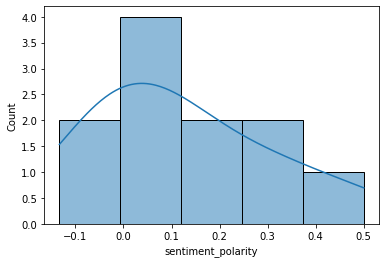

In [16]:
# Count Plot for Sentiment polarity
sns.histplot(data = df['sentiment_polarity'], kde = True)

sentimentsPolarityGraphFilePath = "{0}/result/{1}-SentimentsPolarityGraph.jpg".format(appAnalysisFolderPath, appName)
plt.savefig(sentimentsPolarityGraphFilePath, dpi=100, bbox_inches='tight')

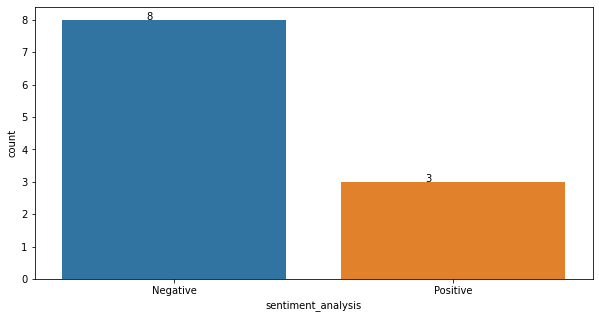

In [17]:
# Count Plot for Sentiment analysis

plt.figure(figsize=(10, 5))
b1 = sns.countplot(x="sentiment_analysis", data=df)

for p in b1.patches:
    b1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.01))

reviewsComparisonGraphFilePath = "{0}/result/{1}-ReviewsComparisonGraph.jpg".format(appAnalysisFolderPath, appName)

plt.savefig(reviewsComparisonGraphFilePath, dpi=100, bbox_inches='tight')

#plt.savefig("test.jpg", dpi=100,bbox_inches='tight')
plt.show()

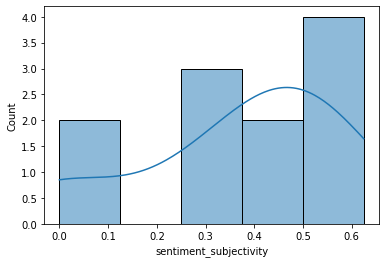

In [18]:
# Count Plot for Sentiment subjectivity


sns.histplot(data = df['sentiment_subjectivity'], kde = True)

sentimentsSubjectivityGraphFilePath = "{0}/result/{1}-SentimentsSubjectivityGraph.jpg".format(appAnalysisFolderPath, appName)
plt.savefig(sentimentsSubjectivityGraphFilePath, dpi=100, bbox_inches='tight')

### b. Wordcloud

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None, polarity = "negative"):
    text = data.tolist()
    text = ' '.join(text).lower()
    
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(text)

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    rel_count = wordcloud.words_
    word_count = wordcloud.process_text(text)
    
    wordCloudFilePath = "{0}/result/wordCloud/{1}-wordCloud-{2}.png".format(appAnalysisFolderPath, appName, polarity)
    wordcloud.to_file(wordCloudFilePath)
    
    plt.imshow(wordcloud)
    plt.show()
    return rel_count,word_count 

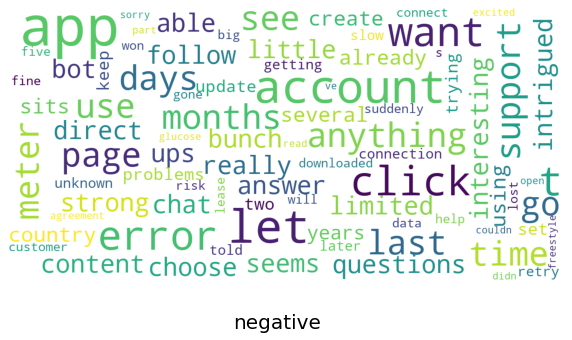

In [20]:
# print wordcloud
n_rel, n_word = show_wordcloud(df_neg["review"],"negative")

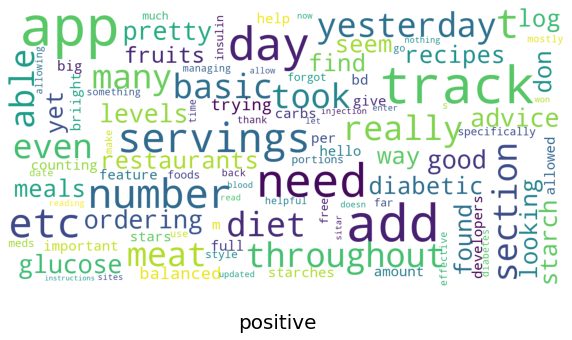

In [21]:
# print wordcloud
p_rel, p_word = show_wordcloud(df_pos["review"],"positive")

### c. Word count

In [22]:
# concat values from 2 dic, if same keys
def merge_dict(d1,d2):
    ds = [d1, d2]
    d = {}
    for k in d1.keys():
      d[k] = tuple(d[k] for d in ds)
    return d

In [23]:
merge_dict(n_rel,n_word)

{'app': (1.0, 6),
 'account': (0.6666666666666666, 4),
 'let': (0.6666666666666666, 4),
 'want': (0.5, 3),
 'click': (0.5, 3),
 'error': (0.5, 3),
 't': (0.5, 3),
 'see': (0.3333333333333333, 2),
 'go': (0.3333333333333333, 2),
 'last': (0.3333333333333333, 2),
 'days': (0.3333333333333333, 2),
 'anything': (0.3333333333333333, 2),
 'page': (0.3333333333333333, 2),
 'support': (0.3333333333333333, 2),
 'time': (0.3333333333333333, 2),
 'months': (0.3333333333333333, 2),
 'use': (0.3333333333333333, 2),
 'meter': (0.3333333333333333, 2),
 'content': (0.16666666666666666, 1),
 'really': (0.16666666666666666, 1),
 'strong': (0.16666666666666666, 1),
 'chat': (0.16666666666666666, 1),
 'bot': (0.16666666666666666, 1),
 'seems': (0.16666666666666666, 1),
 'little': (0.16666666666666666, 1),
 'limited': (0.16666666666666666, 1),
 'answer': (0.16666666666666666, 1),
 'bunch': (0.16666666666666666, 1),
 'questions': (0.16666666666666666, 1),
 'direct': (0.16666666666666666, 1),
 'interesting':

In [24]:
import csv

def saveDictionaryFile(d, filePath):
    field_names = ['Word','Percentage','Occurence']
       
    with open(filePath, "w") as f:
        csv.writer(f).writerow(field_names)
        csv.writer(f).writerows((k,) + v for k, v in d.items())

In [25]:
merge_dict(p_rel,p_word)

{'app': (1.0, 6),
 'track': (0.8333333333333334, 5),
 'add': (0.8333333333333334, 5),
 'day': (0.6666666666666666, 4),
 'need': (0.6666666666666666, 4),
 'etc': (0.5, 3),
 't': (0.5, 3),
 'number': (0.5, 3),
 'servings': (0.5, 3),
 'basic': (0.3333333333333333, 2),
 'really': (0.3333333333333333, 2),
 'diet': (0.3333333333333333, 2),
 'able': (0.3333333333333333, 2),
 'meat': (0.3333333333333333, 2),
 'throughout': (0.3333333333333333, 2),
 'many': (0.3333333333333333, 2),
 'section': (0.3333333333333333, 2),
 'took': (0.3333333333333333, 2),
 'yesterday': (0.3333333333333333, 2),
 'even': (0.3333333333333333, 2),
 'pretty': (0.16666666666666666, 1),
 'good': (0.16666666666666666, 1),
 'glucose': (0.16666666666666666, 1),
 'levels': (0.16666666666666666, 1),
 'advice': (0.16666666666666666, 1),
 'ordering': (0.16666666666666666, 1),
 'restaurants': (0.16666666666666666, 1),
 'recipes': (0.16666666666666666, 1),
 'looking': (0.16666666666666666, 1),
 'way': (0.16666666666666666, 1),
 'm

In [26]:
wordCountDictNegative = merge_dict(n_rel, n_word)
wordCountFilePath = "{0}/result/{1}-WordCountNegative.csv".format(appAnalysisFolderPath,appName)

saveDictionaryFile(wordCountDictNegative, wordCountFilePath)

In [27]:
wordCountDictPositive = merge_dict(p_rel,p_word)
wordCountFilePath = "{0}/result/{1}-WordCountPositive.csv".format(appAnalysisFolderPath,appName)

saveDictionaryFile(wordCountDictPositive, wordCountFilePath)

### d. Key Factor Filters

#### 1. mean score  for word


In [28]:
df_neg[df_neg['review'].str.contains("bluetooth")]['rating'].mean()

# df_pos[df_pos['review'].str.contains("love")]['rating'].mean()

nan

#### 2. relative %  of word for each score 

In [29]:
df_neg[df_neg['review'].str.contains("meter")].groupby('rating')['rating'].count()/df_neg[df_neg['review'].str.contains("meter")]['rating'].count() * 100

# df_neg[df_neg['review'].str.contains("meter")].groupby('rating')['rating'].count()
    

rating
1    100.0
Name: rating, dtype: float64

In [30]:
# define empty dataframe to store matrix
def rating_df():
    return pd.DataFrame(columns=[1,2,3,4,5])

def score_and_keyword_occurence_matrix(source_df, keyword, matrix_df): 
    # '(?i)' to ignore casing using regex
    word_score_count = np.array(source_df[source_df['review'].str.contains('(?i)'+keyword)].groupby('rating')['rating'].count()/source_df[source_df['review'].str.contains('(?i)'+keyword)]['rating'].count() * 100)    
    if len(word_score_count) < 5:
        c = [0.0] * (5-len(word_score_count))
        kw = word_score_count.tolist()
        kw.extend(c)
        matrix_df.loc[keyword] = np.array(kw)    
    else:
        matrix_df.loc[keyword] = word_score_count
    return matrix_df

In [31]:
def buildScoreRelevanceForTopKeyWords(source_df, wordCountDictionary, matrix_df, count=5):
    iterationCount = 0
    
    for k,v in wordCountDictionary.items():
        iterationCount = iterationCount + 1
        # This part of the code can be written in a better manner, taking the easy route for now 
        if (iterationCount <= count): 
            score_and_keyword_occurence_matrix(source_df, k, matrix_df)
        else:
            break
    return 

In [32]:
def getTopCommentsForTopKeyWords(source_df, wordCountDictionary, negativeComments = True, keywordLimit=5, count=10):
    iterationCount = 0
        
    dfComments = source_df.iloc[:0,:].copy()
    keywords = []
    
    for k,v in wordCountDictionary.items():
        iterationCount = iterationCount + 1
        # This part of the code can be written in a better manner, taking the easy route for now 
        if (iterationCount <= keywordLimit): 
            
            order = not negativeComments
            
            x = source_df[source_df['review'
                                  ].str.contains('(?i)'+k)].sort_values(by=['date'], ascending = order).head(count)
            
            # Populate column for keywords                            
            for y in range(len(x)):
                keywords.append(k)
                
            dfComments = dfComments.append(x, ignore_index=True)
            
        else:
            break
    
    # Add Keyword column to the filtered dataframe        
    dfComments["Keyword"] = keywords
    return dfComments

In [33]:
def plot_bar(matrix_df, filePath):
    df_bar = matrix_df.transpose()
    ycol = df_bar.columns.tolist()
    df_bar = df_bar.reset_index()
    
    # plotting graph
    print(df_bar)
    plot = df_bar.plot(x="index", y=ycol, kind="bar", figsize=(7, 5))
    
    fig = plot.get_figure()
    fig.savefig(filePath)   

In [34]:
matrix_df_neg = rating_df()
matrix_df_pos = rating_df()

   index    app  track    add        day   need
0      1  100.0   50.0  100.0  33.333333  100.0
1      2    0.0   50.0    0.0  66.666667    0.0
2      3    0.0    0.0    0.0   0.000000    0.0
3      4    0.0    0.0    0.0   0.000000    0.0
4      5    0.0    0.0    0.0   0.000000    0.0


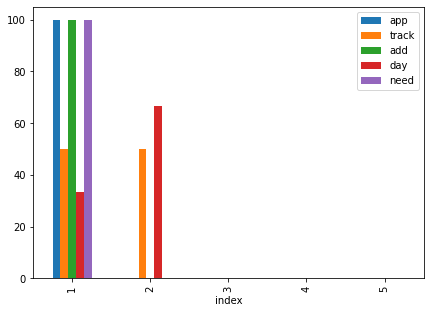

In [35]:
# positive reviews keywords: easy to use, great app, keep track, blood sugar 
matrix_df_pos = rating_df()
buildScoreRelevanceForTopKeyWords(df_pos, wordCountDictPositive, matrix_df_pos, 5)

wordRatingsComparisonFilePath = "{0}/result/{1}-WordsRatingsComparison-Positive.jpg".format(appAnalysisFolderPath, appName)
plot_bar(matrix_df_pos, wordRatingsComparisonFilePath)

   index    app  account    let   want  click
0      1  100.0    100.0  100.0  100.0  100.0
1      2    0.0      0.0    0.0    0.0    0.0
2      3    0.0      0.0    0.0    0.0    0.0
3      4    0.0      0.0    0.0    0.0    0.0
4      5    0.0      0.0    0.0    0.0    0.0


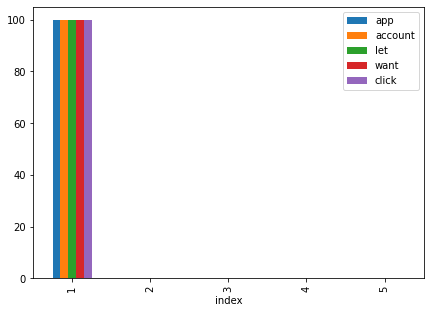

In [36]:
# negative reviews keywords: 
matrix_df_neg = rating_df()
buildScoreRelevanceForTopKeyWords(df_neg, wordCountDictNegative, matrix_df_neg, 5)

wordRatingsComparisonFilePath = "{0}/result/{1}-WordsRatingsComparison-Negative.jpg".format(appAnalysisFolderPath, appName)
plot_bar(matrix_df_neg, wordRatingsComparisonFilePath)

#### 3. 

In [37]:
df_neg[df_neg['review'].str.contains("(?i)privacy")].sort_values(by=['rating'], ascending=True).head(10)

,isEdited,date,rating,title,review,userName,developerResponse,sentiment_polarity,sentiment_analysis,sentiment_subjectivity


In [38]:
def getTopCommentsForTopKeyWords(source_df, wordCountDictionary, negativeComments = True, keywordLimit=5, count=10):
    iterationCount = 0
        
    dfComments = source_df.iloc[:0,:].copy()
    keywords = []
    
    for k,v in wordCountDictionary.items():
        iterationCount = iterationCount + 1
        # This part of the code can be written in a better manner, taking the easy route for now 
        if (iterationCount <= keywordLimit): 
            
            order = not negativeComments
            
            x = source_df[source_df['review'
                                  ].str.contains('(?i)'+k)].sort_values(by=['date'
                                                                           ], ascending = order).head(count)
            
            # Populate column for keywords                            
            for y in range(len(x)):
                keywords.append(k)
                
            dfComments = dfComments.append(x, ignore_index=True)
            
        else:
            break
    
    # Add Keyword column to the filtered dataframe        
    dfComments["Keyword"] = keywords
    return dfComments

In [39]:
# Fetch Top Negative Comments
df_topNegativeComments = getTopCommentsForTopKeyWords(df_neg, wordCountDictNegative, True, 5, 10)

topNegativeReviewsOutputFilePath = "{0}/result/{1}-TopNegativeReviews.csv".format(appAnalysisFolderPath, appName)
df_topNegativeComments.to_csv(topNegativeReviewsOutputFilePath, index=False)

In [40]:
# Fetch Top Positive Comments
df_topPositiveComments = getTopCommentsForTopKeyWords(df_pos, wordCountDictPositive, False, 5, 10)

topPositiveReviewsOutputFilePath = "{0}/result/{1}-TopPositiveReviews.csv".format(appAnalysisFolderPath, appName)
df_topPositiveComments.to_csv(topPositiveReviewsOutputFilePath, index=False)

In [41]:
df['review'][508]

KeyError: 508